In [2]:
!pip install protobuf==3.20.3 --upgrade

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight

print("TensorFlow:", tf.__version__)
print("GPU list:", tf.config.list_physical_devices('GPU'))


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

2025-12-24 11:05:36.586555: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766574336.784745      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766574336.842679      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow: 2.18.0
GPU list: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models

print("TensorFlow:", tf.__version__)
print("GPU list:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.18.0
GPU list: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [4]:
train_dir = "/kaggle/input/fer2013/train"
test_dir  = "/kaggle/input/fer2013/test"

print("Train dir:", train_dir)
print("Test dir :", test_dir)


Train dir: /kaggle/input/fer2013/train
Test dir : /kaggle/input/fer2013/test


In [5]:
!ls /kaggle/input


fer2013


In [6]:
!ls /kaggle/input/fer2013


test  train


In [7]:
train_dir = "/kaggle/input/fer2013/train"
test_dir  = "/kaggle/input/fer2013/test"


In [8]:
IMG_SIZE = 224
BATCH_SIZE = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    label_mode="int",     # 0-6 arası integer
    shuffle=True,
    validation_split=0.1,
    subset="training",
    seed=42
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    label_mode="int",
    shuffle=True,
    validation_split=0.1,
    subset="validation",
    seed=42
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    label_mode="int",
    shuffle=False
)


Found 28709 files belonging to 7 classes.
Using 25839 files for training.


I0000 00:00:1766574357.499113      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766574357.499727      20 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 28709 files belonging to 7 classes.
Using 2870 files for validation.
Found 7178 files belonging to 7 classes.


In [9]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Tüm datasetleri EfficientNet'in istediği formata sok
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds  = test_ds.map(lambda x, y: (preprocess_input(x), y))


In [10]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Sabit class isimleri (map sonrası artık buradan alıyoruz)
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
num_classes = len(class_names)

# train_ds içindeki tüm label'ları tekrar topla
all_labels = []
for _, labels in train_ds:
    all_labels.extend(labels.numpy())

all_labels = np.array(all_labels)

# otomatik dengeli ağırlıklar
class_weights_vals = compute_class_weight(
    class_weight="balanced",
    classes=np.arange(num_classes),
    y=all_labels
)

class_weights = {int(i): float(w) for i, w in enumerate(class_weights_vals)}
print("Class weights before boost:", class_weights)

# 🔥 KASITLI BOOST (disgust, fear, sad)
class_weights[1] *= 2.0   # disgust
class_weights[2] *= 1.5   # fear
class_weights[5] *= 1.3   # sad

print("✅ Class weights after boost:", class_weights)



Class weights before boost: {0: 1.02223365114531, 1: 9.297948902482908, 2: 1.0063483408630627, 3: 0.5660612964707429, 4: 0.8246840291076216, 5: 0.8497434885556433, 6: 1.3080388782018832}
✅ Class weights after boost: {0: 1.02223365114531, 1: 18.595897804965816, 2: 1.509522511294594, 3: 0.5660612964707429, 4: 0.8246840291076216, 5: 1.1046665351223364, 6: 1.3080388782018832}


In [11]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6
    )
]


In [12]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models

# Data augmentation (model içinde kullanılan kısım)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.03),
    layers.RandomZoom(0.05),
], name="data_augmentation")

base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # ilk aşamada donuk

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)          # 👈 AUGMENTATION BURADA
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(7, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385,450 (16.73 MB)

 Trainable params: 332,807 (1.27 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

HEAD_EPOCHS = 30

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=HEAD_EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/30


E0000 00:00:1766574413.492774      20 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1766574415.983052      80 cuda_dnn.cc:529] Loaded cuDNN version 90300


404/404 ━━━━━━━━━━━━━━━━━━━━ 83s 157ms/step - accuracy: 0.2479 - loss: 2.8510 - val_accuracy: 0.4307 - val_loss: 1.4894 - learning_rate: 0.0010
Epoch 2/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 64s 158ms/step - accuracy: 0.3525 - loss: 1.9902 - val_accuracy: 0.4589 - val_loss: 1.4107 - learning_rate: 0.0010
Epoch 3/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 63s 156ms/step - accuracy: 0.3873 - loss: 1.8538 - val_accuracy: 0.4746 - val_loss: 1.3787 - learning_rate: 0.0010
Epoch 4/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 64s 157ms/step - accuracy: 0.3994 - loss: 1.8027 - val_accuracy: 0.4798 - val_loss: 1.3516 - learning_rate: 0.0010
Epoch 5/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 64s 157ms/step - accuracy: 0.4028 - loss: 1.7696 - val_accuracy: 0.5059 - val_loss: 1.3250 - learning_rate: 0.0010
Epoch 6/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 64s 157ms/step - accuracy: 0.4115 - loss: 1.7422 - val_accuracy: 0.5031 - val_loss: 1.3078 - learning_rate: 0.0010
Epoch 7/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 63s 157ms/step - accuracy: 0.4227 - loss:

In [14]:
# ✅ EfficientNet'in bir kısmını açıyoruz
base_model.trainable = True

# Çok erken katmanları açmıyoruz (overfitting olmasın)
for layer in base_model.layers[:-80]:
    layer.trainable = False

# ✅ Daha küçük learning rate ile yeniden compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

FINE_TUNE_EPOCHS = 30

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FINE_TUNE_EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)


Epoch 1/30


E0000 00:00:1766576354.730692      20 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


404/404 ━━━━━━━━━━━━━━━━━━━━ 124s 235ms/step - accuracy: 0.2930 - loss: 2.4446 - val_accuracy: 0.4669 - val_loss: 1.3997 - learning_rate: 1.0000e-04
Epoch 2/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 91s 226ms/step - accuracy: 0.4178 - loss: 1.6782 - val_accuracy: 0.5108 - val_loss: 1.2757 - learning_rate: 1.0000e-04
Epoch 3/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 91s 224ms/step - accuracy: 0.4825 - loss: 1.5134 - val_accuracy: 0.5394 - val_loss: 1.2097 - learning_rate: 1.0000e-04
Epoch 4/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 91s 224ms/step - accuracy: 0.5150 - loss: 1.3679 - val_accuracy: 0.5589 - val_loss: 1.1527 - learning_rate: 1.0000e-04
Epoch 5/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 91s 225ms/step - accuracy: 0.5510 - loss: 1.2650 - val_accuracy: 0.5780 - val_loss: 1.1170 - learning_rate: 1.0000e-04
Epoch 6/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 91s 225ms/step - accuracy: 0.5724 - loss: 1.2225 - val_accuracy: 0.5913 - val_loss: 1.0728 - learning_rate: 1.0000e-04
Epoch 7/30
404/404 ━━━━━━━━━━━━━━━━━━━━ 91s 225ms/step -

In [18]:
test_loss, test_acc = model.evaluate(test_ds)
print("🔥 FINAL TEST ACCURACY:", test_acc)


113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.6228 - loss: 1.0769
🔥 FINAL TEST ACCURACY: 0.6628587245941162


113/113 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step


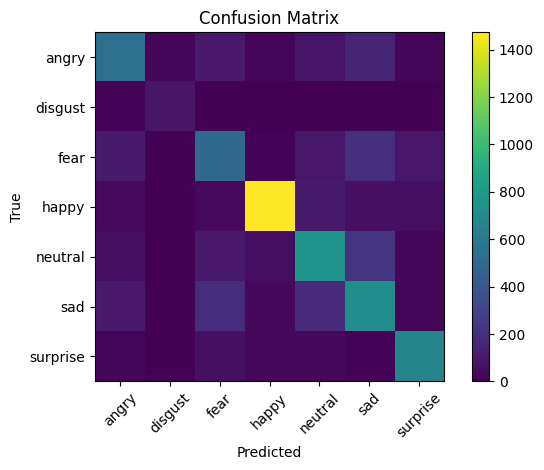

              precision    recall  f1-score   support

       angry       0.62      0.56      0.59       958
     disgust       0.58      0.70      0.63       111
        fear       0.50      0.49      0.50      1024
       happy       0.91      0.83      0.87      1774
     neutral       0.61      0.62      0.62      1233
         sad       0.52      0.58      0.55      1247
    surprise       0.75      0.81      0.78       831

    accuracy                           0.66      7178
   macro avg       0.64      0.66      0.65      7178
weighted avg       0.67      0.66      0.67      7178



In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Gerçek etiketler
y_true = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

# Model tahminleri
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Sınıf isimleri
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Görselleştirme
plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# Detaylı rapor
print(classification_report(y_true, y_pred, target_names=class_names))


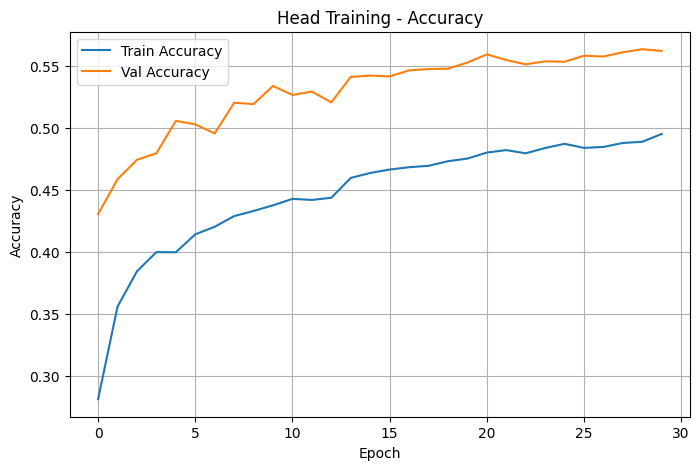

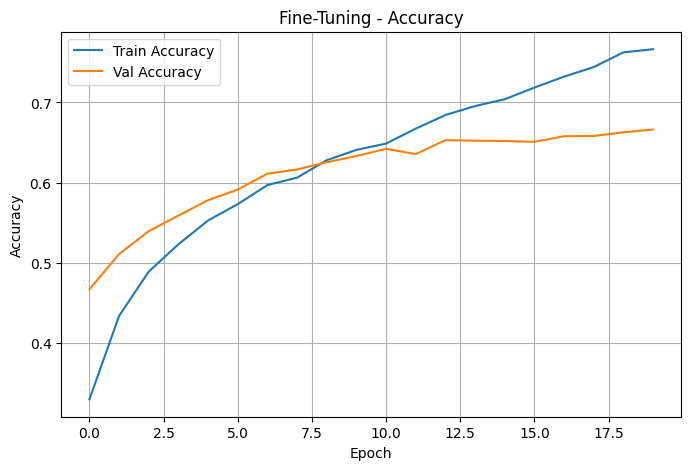

In [20]:
import matplotlib.pyplot as plt

# ----- HEAD TRAINING -----
plt.figure(figsize=(8,5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Head Training - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ----- FINE-TUNING -----
plt.figure(figsize=(8,5))
plt.plot(history_fine.history["accuracy"], label="Train Accuracy")
plt.plot(history_fine.history["val_accuracy"], label="Val Accuracy")
plt.title("Fine-Tuning - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


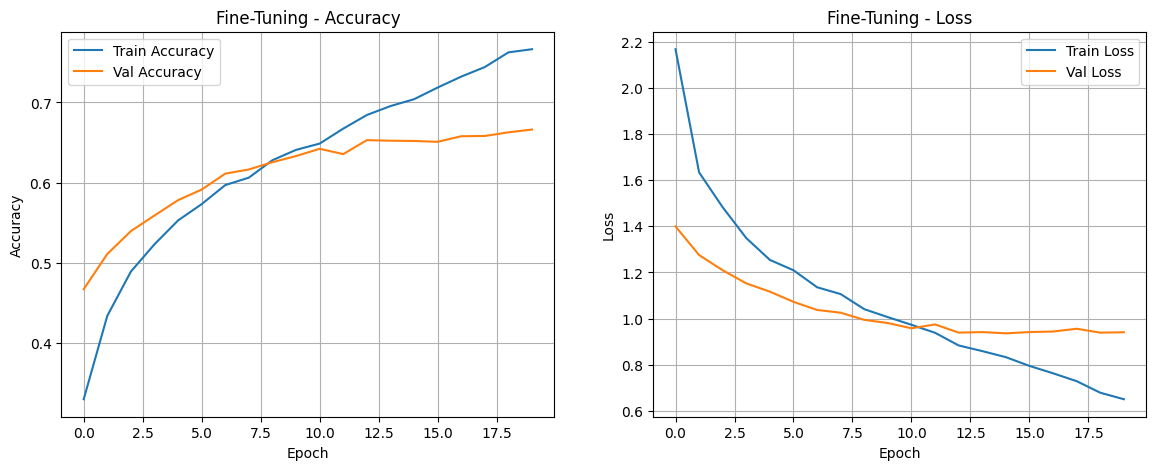

In [21]:
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_fine.history["accuracy"], label="Train Accuracy")
plt.plot(history_fine.history["val_accuracy"], label="Val Accuracy")
plt.title("Fine-Tuning - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history_fine.history["loss"], label="Train Loss")
plt.plot(history_fine.history["val_loss"], label="Val Loss")
plt.title("Fine-Tuning - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()

In [23]:
print("MODEL INPUT SHAPE:", model.input_shape)


MODEL INPUT SHAPE: (None, 224, 224, 3)


In [26]:
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,513,522 (43.92 MB)

 Trainable params: 3,564,035 (13.60 MB)

 Non-trainable params: 821,415 (3.13 MB)

 Optimizer params: 7,128,072 (27.19 MB)

In [27]:
model.save("/kaggle/working/emotion_model_final.keras")


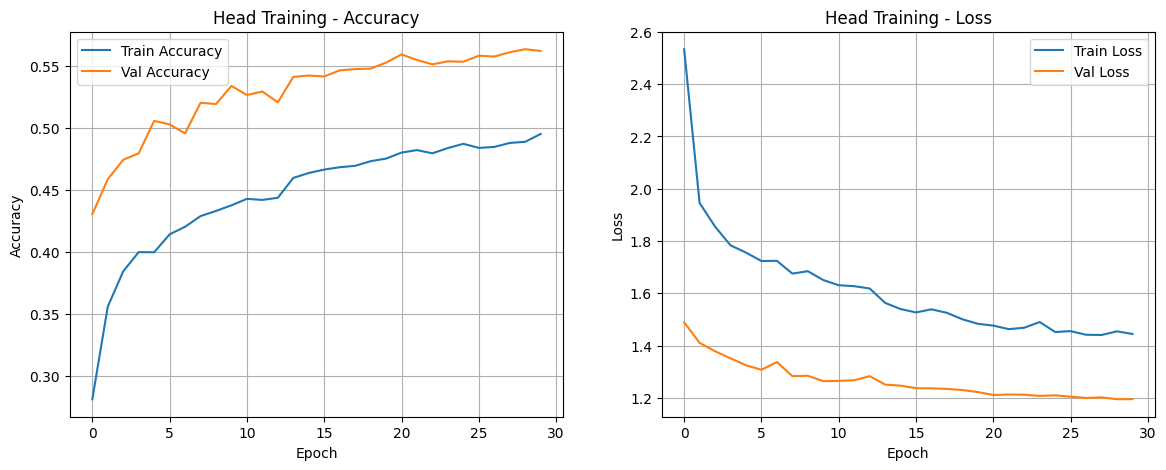

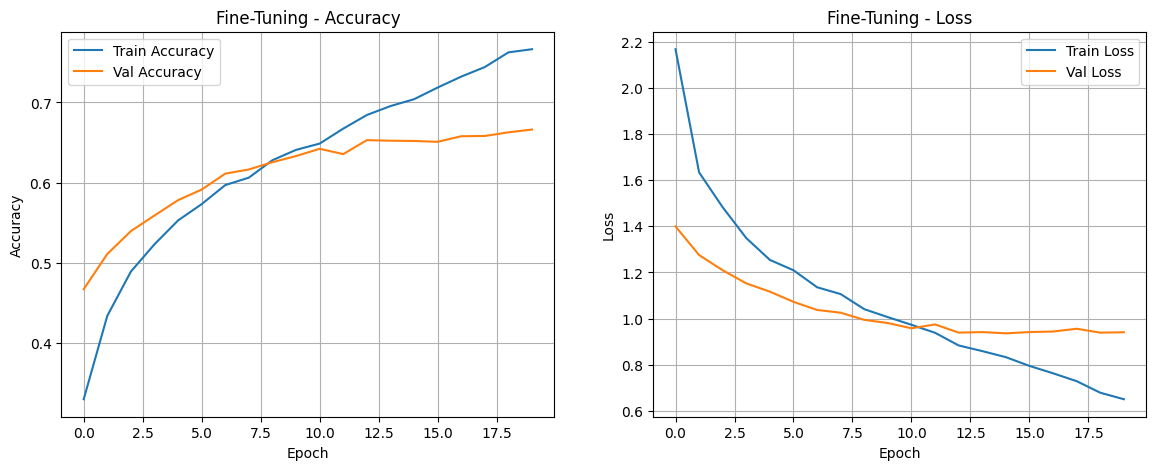

In [28]:
import matplotlib.pyplot as plt

# ================= HEAD TRAINING =================
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("Head Training - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Head Training - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()


# ================= FINE TUNING =================
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_fine.history["accuracy"], label="Train Accuracy")
plt.plot(history_fine.history["val_accuracy"], label="Val Accuracy")
plt.title("Fine-Tuning - Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history_fine.history["loss"], label="Train Loss")
plt.plot(history_fine.history["val_loss"], label="Val Loss")
plt.title("Fine-Tuning - Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.show()
